In [ ]:
!pip install ipdb
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

In [ ]:
import ipdb
# %pdb on

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
from torch.utils.data import DataLoader

## Set device

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f'Using device: {device}')

Using device: mps


# Helper functions

In [3]:
# Set random seed for reproducibility
def set_seed(seed=2024):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(2024)

In [4]:
# Helper function to plot some predictions with the created models
def show_predictions(model, test_loader, device, file_name, num_images=10):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(2, num_images//2, figsize=(15,6))
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                img = images[i].cpu().view(28,28) * 0.5 + 0.5  # Unnormalize
                ax = axes[images_shown//5, images_shown%5]
                ax.imshow(img, cmap='gray')
                ax.set_title(f'P: {preds[i].item()}, A: {labels[i].item()}')
                ax.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

In [5]:
# Helper function to plot the training metrics

def plot_training_metrics(train_acc, val_acc, train_loss, title, save_path):
    # Ensure that all input lists have the same length
    assert len(train_acc) == len(val_acc) == len(train_loss), "All input histories must have the same length."

    epochs = range(1, len(train_acc) + 1)

    # Create the metrics DataFrame
    df_metrics = pd.DataFrame({
        'Epoch': epochs,
        'Training Accuracy (%)': train_acc,
        'Validation Accuracy (%)': val_acc,
        'Training Loss': train_loss
    })

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Training and Validation Accuracy on ax1
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color=color)
    ax1.plot(df_metrics['Epoch'], df_metrics['Training Accuracy (%)'], label='Train Acc', color='tab:blue')
    ax1.plot(df_metrics['Epoch'], df_metrics['Validation Accuracy (%)'], label='Val Acc', color='tab:cyan')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for Training Loss
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Loss', color=color)
    ax2.plot(df_metrics['Epoch'], df_metrics['Training Loss'], label='Train Loss', color='tab:red')
    ax2.tick_params(axis='y', labelcolor=color)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    # Set plot title and layout
    plt.title(title)
    plt.tight_layout()

    # Save and display the plot
    plt.savefig(save_path)
    plt.show()

In [6]:
# Helper function as the training loop
def train_model(model, 
                train_loader, 
                test_loader, 
                criterion, 
                optimizer, 
                device, 
                num_epochs, 
                patience, 
                save_path, 
                verbose=True):
    # Initialize tracking variables
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    best_val_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and correct predictions
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_acc = 100 * correct_val / total_val
        val_acc_history.append(val_acc)
        
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, '
                  f'Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        
        # Early Stopping Check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            if verbose:
                print(f'Validation accuracy improved to {best_val_acc:.2f}%. Model saved to {save_path}')
        else:
            epochs_no_improve += 1
            
            if epochs_no_improve >= patience:
                if verbose:
                    print("Early stopping triggered!")
                break

    return train_acc_history, val_acc_history, train_loss_history

In [7]:
# Helper function to evaluate the performance of the model
def evaluate_model(model, test_loader, device, verbose=True):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_acc = 100 * correct / total
    if verbose:
        print(f'\nFinal Test Accuracy: {final_acc:.2f}%')
    
    return final_acc

# Problem 1: The dataset

In [8]:
# Define the transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the training set
train_dataset = datasets.MNIST(
    root='mnist_data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the test set
test_dataset = datasets.MNIST(
    root='mnist_data',
    train=False,
    download=True,
    transform=transform
)

In [9]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [11]:
train_image = []
train_target = []

for data in train_dataset:
    image, target = data
    train_image.append(image)
    train_target.append(target)

In [12]:
test_image = []
test_target = []

for data in test_dataset:
    image, target = data
    test_image.append(image)
    test_target.append(target)

In [13]:
# Verify dimensions and scaling for training set
for image in train_image:
    assert image.shape == (1, 28, 28), "Image dimensions are incorrect."
    assert torch.all(image >= 0) and torch.all(image <= 1), "Image values are not in [0, 1] range."

# Verify dimensions and scaling for test set
for image in test_image:
    assert image.shape == (1, 28, 28), "Image dimensions are incorrect."
    assert torch.all(image >= 0) and torch.all(image <= 1), "Image values are not in [0, 1] range."

print("All images have correct dimensions and are properly normalized.")


All images have correct dimensions and are properly normalized.


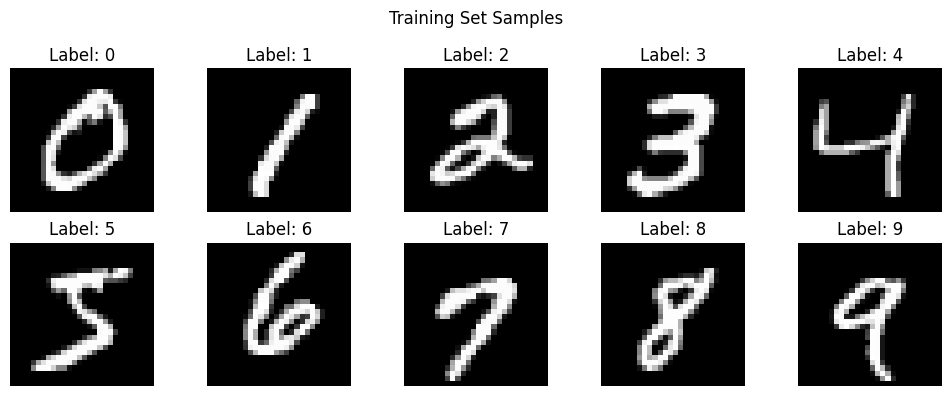

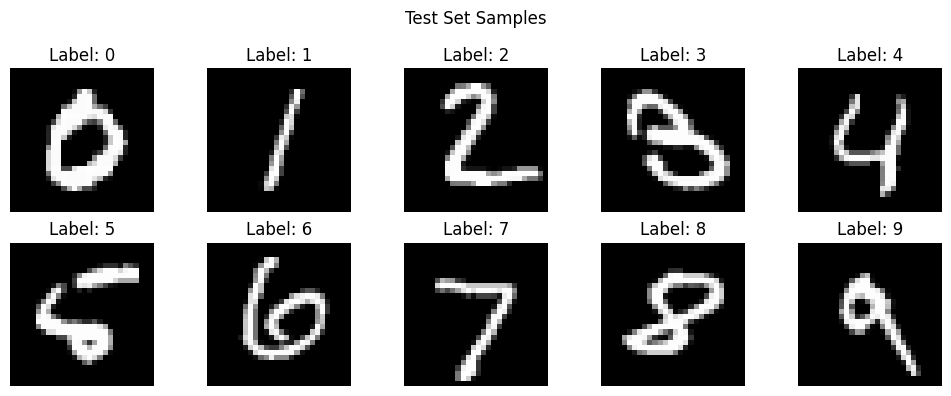

In [14]:
# Function to plot a grid of images
def plot_images(dataset, title, filename):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        # Find the first occurrence of each class
        for image, label in dataset:
            if label == i:
                plt.subplot(2, 5, i+1)
                plt.imshow(image.view(28, 28), cmap='gray')
                plt.title(f'Label: {label}')
                plt.axis('off')
                break
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Plot for training set
plot_images(train_dataset, 'Training Set Samples', 'train_samples.pdf')

# Plot for test set
plot_images(test_dataset, 'Test Set Samples', 'test_samples.pdf')

In [15]:
batch_size = 32
input_size = 28 * 28
num_classes = 10
learning_rate = 0.01
patience = 5  # For early stopping

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Problem 2: Single hidden layer


Hyperparameters:
Input Size: 784
Hidden Size: 500
Number of Classes: 10
Number of Epochs: 50
Batch Size: 32
Learning Rate: 0.01
Early Stopping Patience: 5

Epoch [1/50], Loss: 0.5390, Train Acc: 85.97%, Val Acc: 90.42%
Validation accuracy improved to 90.42%. Model saved to best_mnist_model.pth
Epoch [2/50], Loss: 0.3059, Train Acc: 91.16%, Val Acc: 92.42%
Validation accuracy improved to 92.42%. Model saved to best_mnist_model.pth
Epoch [3/50], Loss: 0.2578, Train Acc: 92.55%, Val Acc: 93.32%
Validation accuracy improved to 93.32%. Model saved to best_mnist_model.pth
Epoch [4/50], Loss: 0.2201, Train Acc: 93.75%, Val Acc: 93.88%
Validation accuracy improved to 93.88%. Model saved to best_mnist_model.pth
Epoch [5/50], Loss: 0.1903, Train Acc: 94.63%, Val Acc: 94.98%
Validation accuracy improved to 94.98%. Model saved to best_mnist_model.pth
Epoch [6/50], Loss: 0.1677, Train Acc: 95.29%, Val Acc: 95.41%
Validation accuracy improved to 95.41%. Model saved to best_mnist_model.pth
Epoch [7/

/var/folders/qw/7m__jx3s1d7c59k4hvfhjv940000gn/T/ipykernel_68810/3155968488.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mnist

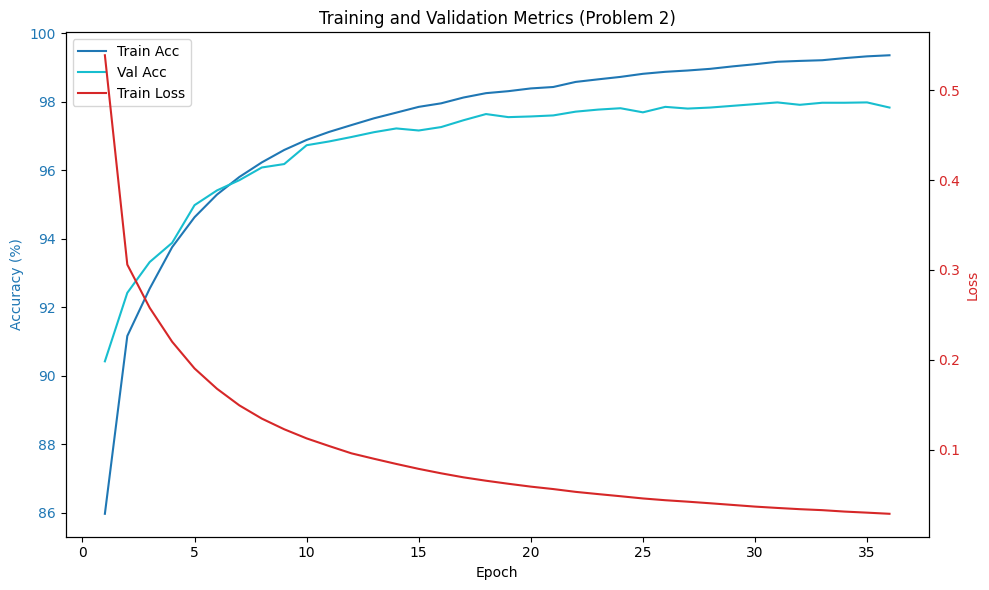

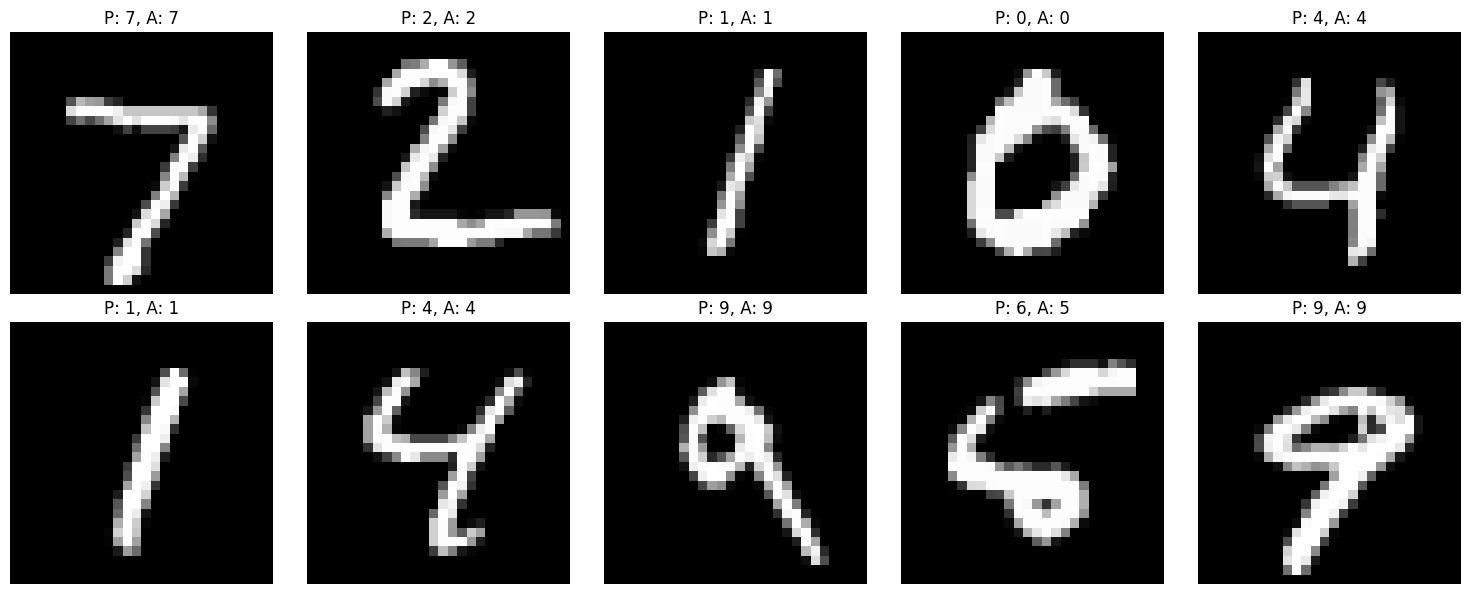


Final Test Accuracy: 97.98%
Trained model saved as 'mnist_model_final_2.pth'


In [16]:
# Hyperparameters
hidden_size = 500
num_epochs = 50

print("\nHyperparameters:")
print(f"Input Size: {input_size}")
print(f"Hidden Size: {hidden_size}")
print(f"Number of Classes: {num_classes}")
print(f"Number of Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Early Stopping Patience: {patience}\n")

# Neural Network definition
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize model, loss, optimizer
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

save_path_p2 = 'best_mnist_model_2.pth'

train_acc_history, val_acc_history, train_loss_history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    patience=patience,
    save_path=save_path_p2,
    verbose=True
)

# Load the best model
model.load_state_dict(torch.load('best_mnist_model_2.pth'))

# Plot metrics with combined axes
plot_training_metrics(
    train_acc=train_acc_history,
    val_acc=val_acc_history,
    train_loss=train_loss_history,
    title='Training and validation metrics (Problem 2)',
    save_path='training_validation_metrics_2.pdf'
)

# Display example predictions
show_predictions(model, test_loader, device, "example_predictions_2.pdf", num_images=10)

# Final evaluation
final_acc_p2 = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    verbose=True
)

# Save the trained model
torch.save(model.state_dict(), 'mnist_model_final_2.pth')
print("Trained model saved as 'mnist_model_final_2.pth'")


# Problem 3: Two hidden layers


Hyperparameters:
Input Size: 784
Hidden Size 1: 500
Hidden Size 2: 300
Number of Classes: 10
Number of Epochs: 40
Batch Size: 32
Learning Rate: 0.01
L2 Weight Decay: 0.001
Early Stopping Patience: 5

Epoch [1/40], Loss: 0.6566, Train Acc: 82.42%, Val Acc: 90.09%
Validation accuracy improved to 90.09%. Model saved to best_mnist_model_3.pth
Epoch [2/40], Loss: 0.3030, Train Acc: 91.20%, Val Acc: 92.61%
Validation accuracy improved to 92.61%. Model saved to best_mnist_model_3.pth
Epoch [3/40], Loss: 0.2499, Train Acc: 92.62%, Val Acc: 93.86%
Validation accuracy improved to 93.86%. Model saved to best_mnist_model_3.pth
Epoch [4/40], Loss: 0.2090, Train Acc: 93.88%, Val Acc: 94.33%
Validation accuracy improved to 94.33%. Model saved to best_mnist_model_3.pth
Epoch [5/40], Loss: 0.1792, Train Acc: 94.80%, Val Acc: 95.18%
Validation accuracy improved to 95.18%. Model saved to best_mnist_model_3.pth
Epoch [6/40], Loss: 0.1553, Train Acc: 95.50%, Val Acc: 95.62%
Validation accuracy improved to

/var/folders/qw/7m__jx3s1d7c59k4hvfhjv940000gn/T/ipykernel_68810/184243802.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mnist_

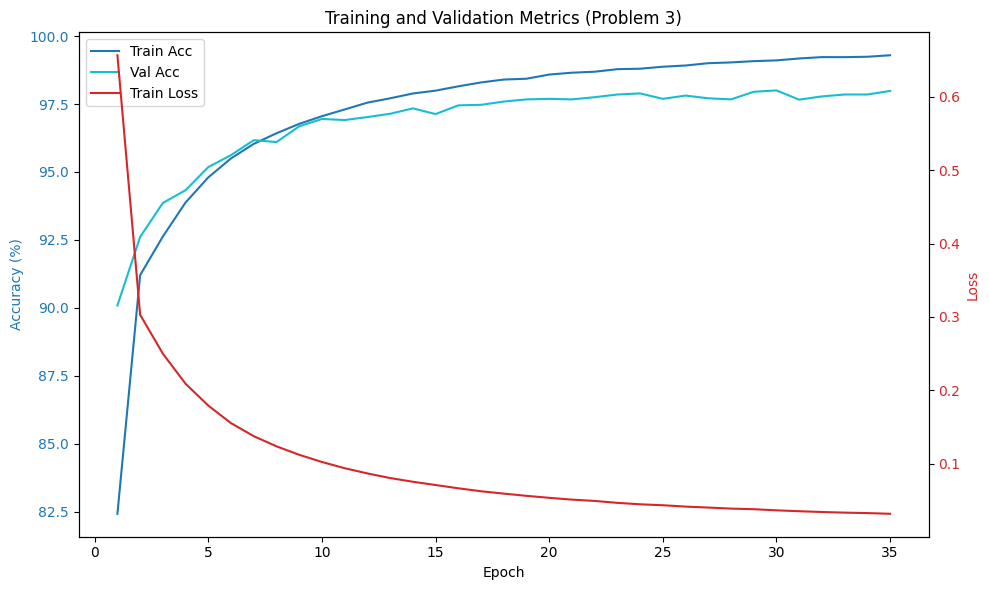

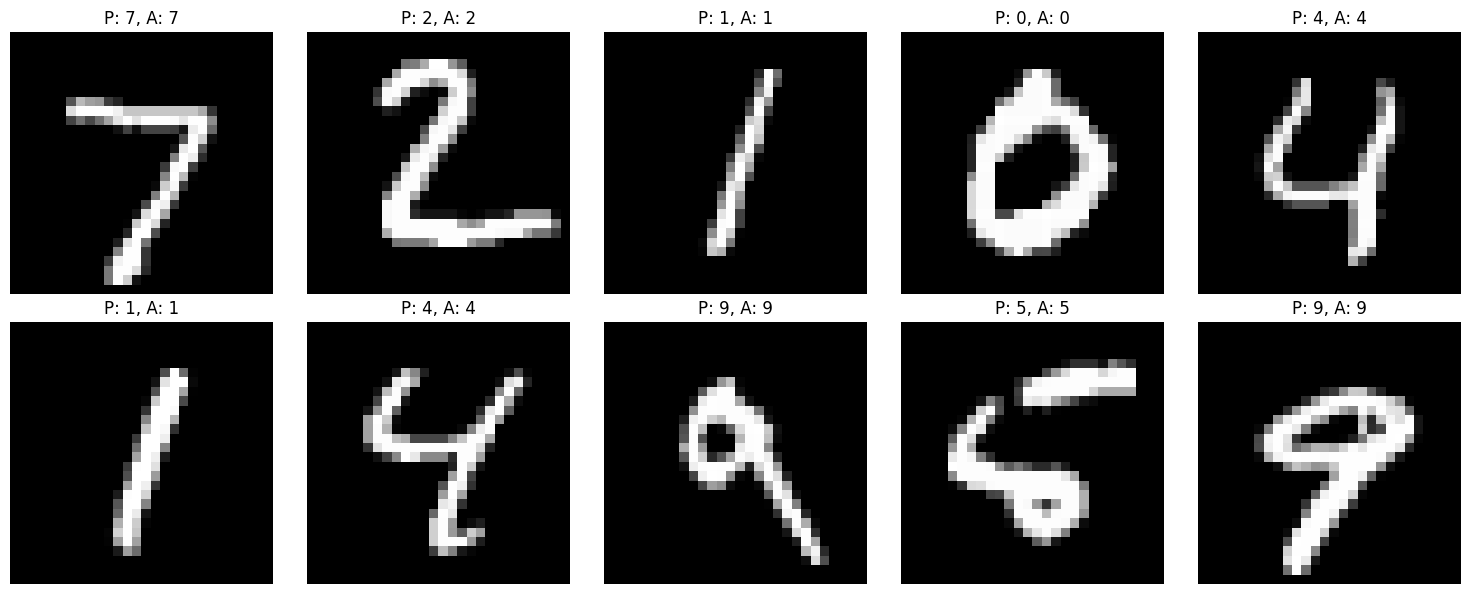


Final Test Accuracy: 98.00%
Trained model saved as 'mnist_model_final_3.pth'


In [17]:
# Hyperparameters
hidden_size_1 = 500
hidden_size_2 = 300
num_epochs = 40
weight_decay = 0.001  # L2 regularization

print("\nHyperparameters:")
print(f"Input Size: {input_size}")
print(f"Hidden Size 1: {hidden_size_1}")
print(f"Hidden Size 2: {hidden_size_2}")
print(f"Number of Classes: {num_classes}")
print(f"Number of Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"L2 Weight Decay: {weight_decay}")
print(f"Early Stopping Patience: {patience}\n")


# Neural Network with two hidden layers
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(NeuralNet2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Initialize model, loss, optimizer
model = NeuralNet2(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

save_path_p3 = 'best_mnist_model_3.pth'

train_acc_history, val_acc_history, train_loss_history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    patience=patience,
    save_path=save_path_p3,
    verbose=True
)

# Load the best model
model.load_state_dict(torch.load('best_mnist_model_3.pth'))

# Plot metrics with combined axes
plot_training_metrics(
    train_acc=train_acc_history,
    val_acc=val_acc_history,
    train_loss=train_loss_history,
    title='Training and validation metrics (Problem 3)',
    save_path='training_validation_metrics_3.pdf'
)

# Display example predictions
show_predictions(model, test_loader, device, 'example_predictions_3.pdf',num_images=10)

# Final evaluation
final_acc_p3 = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    verbose=True
)

# Save the trained model
torch.save(model.state_dict(), 'mnist_model_final_3.pth')
print("Trained model saved as 'mnist_model_final_3.pth'")

# Problem 4: Convolutional Neural Network


Hyperparameters:
Input Channels: 1
Number of Classes: 10
Number of Epochs: 40
Batch Size: 100
Learning Rate: 0.01
L2 Weight Decay: 0.0005
Early Stopping Patience: 5

Epoch [1/40], Loss: 1.3386, Train Acc: 60.78%, Val Acc: 90.43%
Validation accuracy improved to 90.43%. Model saved to best_cnn_model.pth
Epoch [2/40], Loss: 0.3780, Train Acc: 88.90%, Val Acc: 94.48%
Validation accuracy improved to 94.48%. Model saved to best_cnn_model.pth
Epoch [3/40], Loss: 0.2477, Train Acc: 92.78%, Val Acc: 95.89%
Validation accuracy improved to 95.89%. Model saved to best_cnn_model.pth
Epoch [4/40], Loss: 0.1861, Train Acc: 94.53%, Val Acc: 96.75%
Validation accuracy improved to 96.75%. Model saved to best_cnn_model.pth
Epoch [5/40], Loss: 0.1556, Train Acc: 95.57%, Val Acc: 97.11%
Validation accuracy improved to 97.11%. Model saved to best_cnn_model.pth
Epoch [6/40], Loss: 0.1347, Train Acc: 96.18%, Val Acc: 97.60%
Validation accuracy improved to 97.60%. Model saved to best_cnn_model.pth
Epoch [7/40

/var/folders/qw/7m__jx3s1d7c59k4hvfhjv940000gn/T/ipykernel_68810/3033275790.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_m

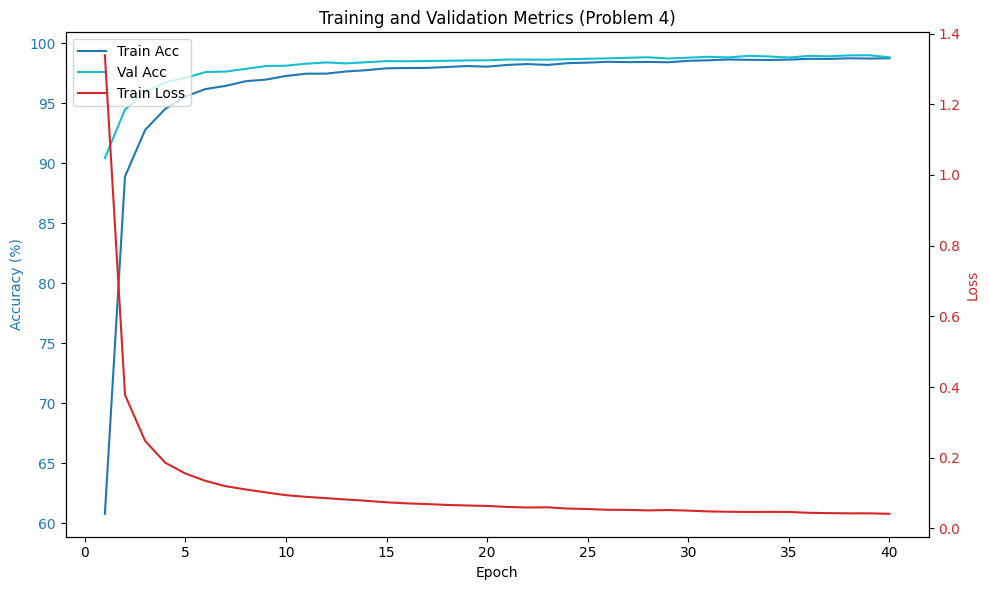

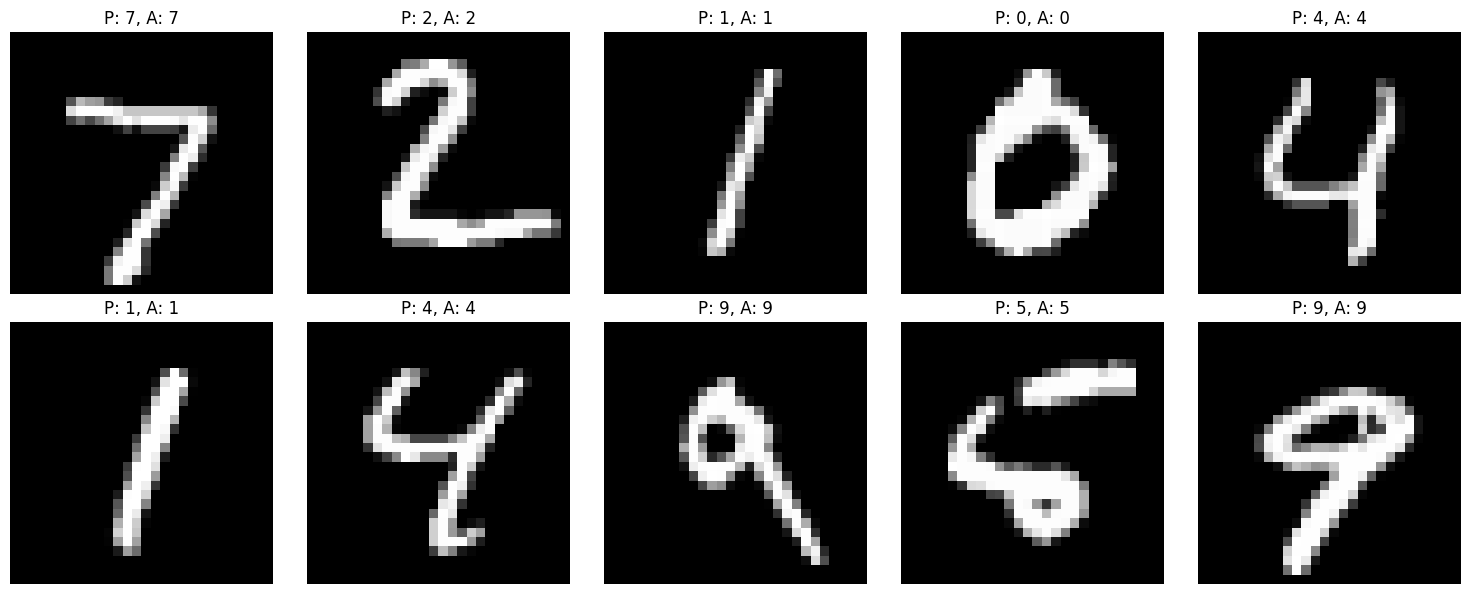


Final Test Accuracy: 99.00%
Trained model saved as 'cnn_model_final.pth'


In [18]:
# Hyperparameters
input_channels = 1 # Grayscale images
num_epochs = 40
batch_size = 100
weight_decay = 0.0005 # L2 regularization strength

print("\nHyperparameters:")
print(f"Input Channels: {input_channels}")
print(f"Number of Classes: {num_classes}")
print(f"Number of Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"L2 Weight Decay: {weight_decay}")
print(f"Early Stopping Patience: {patience}\n")

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First Convolutional Layer
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # Output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 32x14x14
        )
        # Second Convolutional Layer
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x7x7
        )
        # Fully Connected Layers
        self.fc_layer = nn.Sequential(
            nn.Linear(7 * 7 * 64, 128), # Flatten and reduce dimensions
            nn.ReLU(),
            nn.Dropout(p=0.5), # Dropout for regularization
            nn.Linear(128, num_classes) # Output layer
        )
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc_layer(out)
        return out

# Initialize model, loss, pptimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

save_path_p4 = 'best_cnn_model.pth'

train_acc_history, val_acc_history, train_loss_history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    patience=patience,
    save_path=save_path_p4,
    verbose=True
)

# Load Best Model
model.load_state_dict(torch.load('best_cnn_model.pth'))

# Combined plot
plot_training_metrics(
    train_acc=train_acc_history,
    val_acc=val_acc_history,
    train_loss=train_loss_history,
    title='Training and validation metrics (Problem 4)',
    save_path='training_validation_metrics_cnn.pdf'
)

# Example predictions
show_predictions(model, test_loader, device, 'example_predictions_cnn.pdf',num_images=10)

# Final evaluation
final_acc_p4 = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    verbose=True
)

# Save the trained model
torch.save(model.state_dict(), 'cnn_model_final.pth')
print("Trained model saved as 'cnn_model_final.pth'")